In [1]:
library(repr)
options(repr.plot.width=7, repr.plot.height=5)

In [4]:
options(warn = -1)

In [1]:
library(DiffBind)
library(tidyverse)
library(GenomicRanges)

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Loading required package: S4Vecto

# Prep for chromVAR

### Use `DiffBind` to combine peaks from all the samples

`DiffBind` takes inputs of peaks and bams, which is all annotated and constructed in `/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/atac/samplesheet.csv`

**Peaks:** Peaks are narrow peaks called by MACS2, pre-processed by centering at summit with uniform width of 500bp. `/c/groups/sanjana_lab/cdai/TFscreen/atac/macs2/v7/ATAC*_500_Peaks.bed`

**Bams:** Bams are aligned by bwa, prefiltered suing mapq>20, and properly paired (all pair end). See `ATAC_bash.ipynb` for detailed processing scripts and procedures. `/c/groups/sanjana_lab/cdai/TFscreen/atac/bams_v3/ATAC*.PE.mapq.bam`

**DiffBind Processing**
1. read in peaks
2. construct consensus peak sets. Here using `minOverlap=2`, which means each peak must exist in at least 2 samples in order to be included in consensus peak sets. Since we have 2 replicates for each sample, 2 is a reasonable choice.
3. The result of `step 2` includes the consensus peaks for all 12 samples. Since chromVAR only needs the peak intervals, we can just take a peak set from any of the 12 samples. (Each sample has the same rows of peak intervals, albeit different reads, scores, etc.)
4. The output of peakset (ready for `chromVAR`) is **`/c/groups/sanjana_lab/cdai/TFscreen/atac/diffbind_consensu_min2overlap.bed`**

**Construct consensus peak sets with read counts** (useful for chomVAR and my own DESeq2)

Output files:
- Consensus peak set with chr, start, end, in `bed` format, good for chromVAR. `diffbind_consensu_min2overlap.bed`
- Read count matrix for the consensu peak set. No coordinate columns,  for chromVAR. `diffbind_consensu_min2overlap_readcounts.txt`
- Consensus peak set read counts with peak coordinates. Good for DESeq.`diffbind_consensu_min2overlap_readcounts_with_coordinates.txt`


---
code original

In [4]:
setwd("/c/groups/sanjana_lab/cdai/TFscreen/atac/")

In [5]:
samplesheet.file <- "/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/atac/samplesheet2.csv"
peaks.for.diffbind <- dba(sampleSheet = samplesheet.file, peakCaller="macs")

# get counts, but the point here is to construct consensus peakset
peaks.for.diffbind <- dba.count(peaks.for.diffbind, minOverlap = 2, summits = 250)

diffbind_consensus_min2overlap <- peaks.for.diffbind$peaks[[1]] %>% 
                                    filter(str_detect(Chr,"chr[0-9XY]+"))

# only need to run once
diffbind_consensus_min2overlap %>% select(Chr, Start, End) %>% 
        write.table("diffbind_consensu_min2overlap.bed", quote = F, sep = "\t", row.names = F, col.names = F)

# construct count matrix for the peaks
nrows = dim(diffbind_consensus_min2overlap)[1]
peak.cnt.m = matrix(0, nrow=nrows, ncol=12)
for (i in 1:12) {
    diffbind_consensus_min2overlap <- peaks.for.diffbind$peaks[[i]] %>% 
                                    filter(str_detect(Chr,"chr[0-9XY]+"))
    counts <- diffbind_consensus_min2overlap %>% pull("Reads")
    peak.cnt.m[,i] = counts
}
peak.cnt.m <- as.data.frame(peak.cnt.m)
colnames(peak.cnt.m) <- as.vector(peaks.for.diffbind$samples$SampleID) # add column names

peak.cnt.m %>% write.table("diffbind_consensu_min2overlap_readcounts.txt", sep="\t", 
                           quote = F, row.names = F, col.names = T)

A1 ESC TF ESC Full 1 macs

A2 ESC TF ESC Full 2 macs

A3 Neuron TF 1H Full 1 macs

A4 Neuron TF 1H Full 2 macs

A5 Neuron TF 4H Full 1 macs

A6 Neuron TF 4H Full 2 macs

A7 Neuron TF 16H Full 1 macs

A8 Neuron TF 16H Full 2 macs

A9 Neuron TF 24H Full 1 macs

A10 Neuron TF 24H Full 2 macs

A11 Neuron TF 5D Full 1 macs

A12 Neuron TF 5D Full 2 macs

Re-centering peaks...



In [120]:
df <- read.table("diffbind_consensu_min2overlap_readcounts_with_coordinates.txt", header = T)

In [123]:
df %>% write.table("diffbind_consensu_min2overlap_readcounts_with_coordinates.bed", sep = '\t',quote = F, row.names = F, col.names = F)

Code original

---


## Only use diffbind to get consensus peaks. Do not resize, recenter. 

In [104]:
samplesheet.file <- "/gpfs/commons/groups/sanjana_lab/cdai/TFscreen/atac/samplesheet2.csv"
peaks <- dba(sampleSheet = samplesheet.file, peakCaller = "macs", minOverlap=2, bRemoveRandom=T, bRemoveM=T)

A1 ESC TF ESC Full 1 macs

A2 ESC TF ESC Full 2 macs

A3 Neuron TF 1H Full 1 macs

A4 Neuron TF 1H Full 2 macs

A5 Neuron TF 4H Full 1 macs

A6 Neuron TF 4H Full 2 macs

A7 Neuron TF 16H Full 1 macs

A8 Neuron TF 16H Full 2 macs

A9 Neuron TF 24H Full 1 macs

A10 Neuron TF 24H Full 2 macs

A11 Neuron TF 5D Full 1 macs

A12 Neuron TF 5D Full 2 macs



In [110]:
# get counts, and construct consensus peakset that has min 2 overlaps
peaks_counts <- dba.count(peaks, minOverlap = 2, score = DBA_SCORE_READS)

In [143]:
# get read counts of consensus peak set
consensus_peaks <- peaks_counts$peaks[[1]] %>% 
                    select(Chr, Start, End) %>% 
                    cbind(., peaks_counts$binding %>% as.data.frame %>% select(A1:A12)) %>%
                    filter(., str_detect(Chr, "^chr.*[0-9XY]$"))

In [147]:
write.table(consensus_peaks, "diffbind/diffbind_consensu_min2overlap_NO_RECENTER.txt", sep = '\t',quote = F, row.names = F, col.names = T)

---

# DiffBind analysis

Here, we reuse the count matrix done from previous section

In [9]:
peaks <- peaks.for.diffbind

In [74]:
peaks

12 Samples, 116232 sites in matrix:
    ID Tissue Factor Condition Treatment Replicate Caller Intervals FRiP
1   A1    ESC     TF       ESC      Full         1 counts    116232 0.12
2   A2    ESC     TF       ESC      Full         2 counts    116232 0.11
3   A3 Neuron     TF        1H      Full         1 counts    116232 0.10
4   A4 Neuron     TF        1H      Full         2 counts    116232 0.10
5   A5 Neuron     TF        4H      Full         1 counts    116232 0.12
6   A6 Neuron     TF        4H      Full         2 counts    116232 0.12
7   A7 Neuron     TF       16H      Full         1 counts    116232 0.11
8   A8 Neuron     TF       16H      Full         2 counts    116232 0.14
9   A9 Neuron     TF       24H      Full         1 counts    116232 0.13
10 A10 Neuron     TF       24H      Full         2 counts    116232 0.12
11 A11 Neuron     TF        5D      Full         1 counts    116232 0.18
12 A12 Neuron     TF        5D      Full         2 counts    116232 0.17

15 Contrasts:


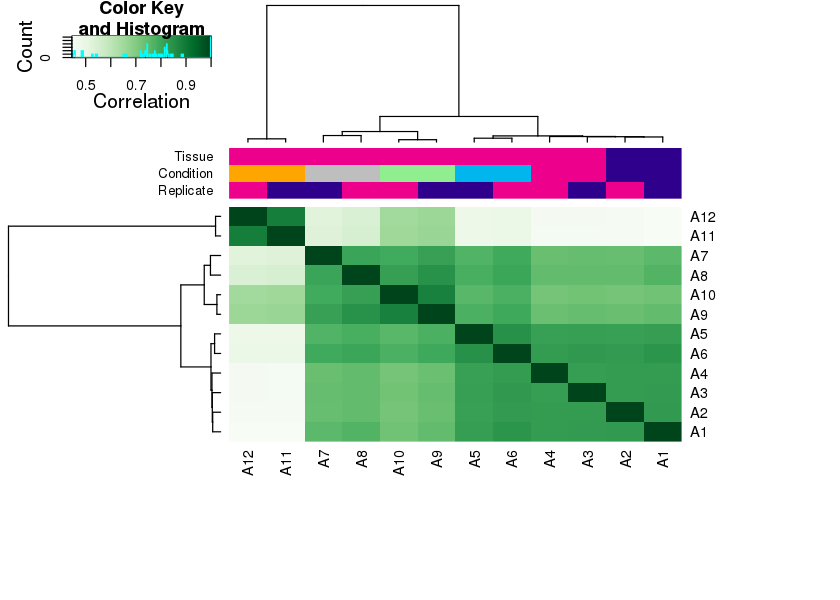

In [13]:
plot(peaks)

In [14]:
peaks <- dba.contrast(peaks, categories = DBA_CONDITION, minMembers = 2) # set up contrasts (pairwise comparisons)

In [18]:
peaks

12 Samples, 116232 sites in matrix:
    ID Tissue Factor Condition Treatment Replicate Caller Intervals FRiP
1   A1    ESC     TF       ESC      Full         1 counts    116232 0.12
2   A2    ESC     TF       ESC      Full         2 counts    116232 0.11
3   A3 Neuron     TF        1H      Full         1 counts    116232 0.10
4   A4 Neuron     TF        1H      Full         2 counts    116232 0.10
5   A5 Neuron     TF        4H      Full         1 counts    116232 0.12
6   A6 Neuron     TF        4H      Full         2 counts    116232 0.12
7   A7 Neuron     TF       16H      Full         1 counts    116232 0.11
8   A8 Neuron     TF       16H      Full         2 counts    116232 0.14
9   A9 Neuron     TF       24H      Full         1 counts    116232 0.13
10 A10 Neuron     TF       24H      Full         2 counts    116232 0.12
11 A11 Neuron     TF        5D      Full         1 counts    116232 0.18
12 A12 Neuron     TF        5D      Full         2 counts    116232 0.17

15 Contrasts:


In [16]:
peaks <- dba.analyze(peaks) # analyze peaks

##### As expected: observe higher amount of differential peaks as time goes on.

In [19]:
peaks

12 Samples, 116232 sites in matrix:
    ID Tissue Factor Condition Treatment Replicate Caller Intervals FRiP
1   A1    ESC     TF       ESC      Full         1 counts    116232 0.12
2   A2    ESC     TF       ESC      Full         2 counts    116232 0.11
3   A3 Neuron     TF        1H      Full         1 counts    116232 0.10
4   A4 Neuron     TF        1H      Full         2 counts    116232 0.10
5   A5 Neuron     TF        4H      Full         1 counts    116232 0.12
6   A6 Neuron     TF        4H      Full         2 counts    116232 0.12
7   A7 Neuron     TF       16H      Full         1 counts    116232 0.11
8   A8 Neuron     TF       16H      Full         2 counts    116232 0.14
9   A9 Neuron     TF       24H      Full         1 counts    116232 0.13
10 A10 Neuron     TF       24H      Full         2 counts    116232 0.12
11 A11 Neuron     TF        5D      Full         1 counts    116232 0.18
12 A12 Neuron     TF        5D      Full         2 counts    116232 0.17

15 Contrasts:


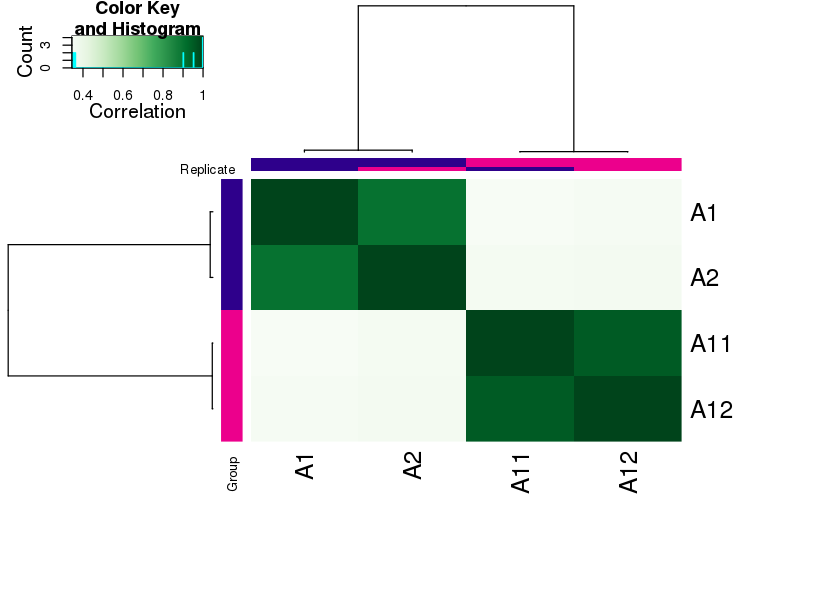

In [21]:
plot(peaks, contrast=5) # 5D vs. ES

In [22]:
peaks.5D <- dba.report(peaks, contrast = 5) # 5D vs. ES

In [25]:
peaks.5D

GRanges object with 38923 ranges and 6 metadata columns:
         seqnames              ranges strand |      Conc  Conc_ESC   Conc_5D
            <Rle>           <IRanges>  <Rle> | <numeric> <numeric> <numeric>
   53864     chr2   48196112-48196612      * |      8.25      4.54      9.19
   38529    chr16   22681478-22681978      * |      8.12      4.85      9.05
    8286     chr1 205030954-205031454      * |      8.16      5.31      9.06
    3971     chr1   69071682-69072182      * |      7.99      4.34      8.93
  107485     chr9   23537638-23538138      * |      8.45      6.13      9.29
     ...      ...                 ...    ... .       ...       ...       ...
   24968    chr12   83955089-83955589      * |      4.32      4.89      3.36
   22344    chr12     6268687-6269187      * |      4.96      5.43      4.25
   14773    chr10 112898682-112899182      * |      5.75      6.17      5.16
   27870    chr13   33391377-33391877      * |      4.53      3.65      5.07
   44893    chr17  

In [30]:
peaks.5D %>% as.data.frame %>% head(10)

,seqnames,start,end,width,strand,Conc,Conc_ESC,Conc_5D,Fold,p.value,FDR
,<fct>,<int>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
53864,chr2,48196112,48196612,501,*,8.25,4.54,9.19,-4.65,1.79e-74,2.08e-69
38529,chr16,22681478,22681978,501,*,8.12,4.85,9.05,-4.20,1.11e-67,6.43e-63
8286,chr1,205030954,205031454,501,*,8.16,5.31,9.06,-3.75,1.31e-63,5.06e-59
3971,chr1,69071682,69072182,501,*,7.99,4.34,8.93,-4.59,1.88e-62,5.48e-58
107485,chr9,23537638,23538138,501,*,8.45,6.13,9.29,-3.16,1.16e-61,2.70e-57
81278,chr5,3489265,3489765,501,*,7.88,4.53,8.81,-4.28,9.17e-59,1.78e-54
94673,chr6,170243787,170244287,501,*,7.84,4.40,8.77,-4.37,3.51e-57,5.83e-53
18136,chr11,57597851,57598351,501,*,8.79,6.93,9.57,-2.64,1.28e-56,1.86e-52
49655,chr19,19485077,19485577,501,*,7.79,4.38,8.72,-4.35,2.80e-55,3.62e-51


In [32]:
peaks.24H <- dba.report(peaks, contrast = 4) # 24H vs ES

In [33]:
peaks.24H

GRanges object with 5861 ranges and 6 metadata columns:
         seqnames              ranges strand |      Conc  Conc_ESC  Conc_24H
            <Rle>           <IRanges>  <Rle> | <numeric> <numeric> <numeric>
   53864     chr2   48196112-48196612      * |      6.98       4.6      7.83
   57654     chr2 155748152-155748652      * |      7.07      4.97      7.89
   33437    chr14   96754708-96755208      * |      6.84      4.71      7.66
   14680    chr10 110725789-110726289      * |      6.79      4.65      7.62
   30281    chr13 109301626-109302126      * |      6.51      3.81      7.39
     ...      ...                 ...    ... .       ...       ...       ...
   15577    chr10 128867038-128867538      * |      4.33      3.11      4.99
   63944    chr20   62376381-62376881      * |      6.85      7.17      6.45
   68945     chr3   41138049-41138549      * |      4.26      2.96      4.93
  103414     chr8   60997103-60997603      * |      5.14      4.14      5.72
   69315     chr3   

In [71]:
peaks.5D %>% as.data.frame %>% head(10)

,seqnames,start,end,width,strand,Conc,Conc_ESC,Conc_5D,Fold,p.value,FDR
,<fct>,<int>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
53864,chr2,48196112,48196612,501,*,8.25,4.54,9.19,-4.65,1.79e-74,2.08e-69
38529,chr16,22681478,22681978,501,*,8.12,4.85,9.05,-4.20,1.11e-67,6.43e-63
8286,chr1,205030954,205031454,501,*,8.16,5.31,9.06,-3.75,1.31e-63,5.06e-59
3971,chr1,69071682,69072182,501,*,7.99,4.34,8.93,-4.59,1.88e-62,5.48e-58
107485,chr9,23537638,23538138,501,*,8.45,6.13,9.29,-3.16,1.16e-61,2.70e-57
81278,chr5,3489265,3489765,501,*,7.88,4.53,8.81,-4.28,9.17e-59,1.78e-54
94673,chr6,170243787,170244287,501,*,7.84,4.40,8.77,-4.37,3.51e-57,5.83e-53
18136,chr11,57597851,57598351,501,*,8.79,6.93,9.57,-2.64,1.28e-56,1.86e-52
49655,chr19,19485077,19485577,501,*,7.79,4.38,8.72,-4.35,2.80e-55,3.62e-51


In [35]:
gtf <- read.table("/c/groups/sanjana_lab/cdai/ref_genome/gencode.v31.primary_assembly.annotation.pandas.df.txt", sep="\t", stringsAsFactors = F, header = T)

In [36]:
gtf <- gtf %>% filter(feature == 'gene' & gene_type == "protein_coding" ) %>% dplyr::select(seqname, start, end, strand, gene_id, gene_name, gene_type)

In [37]:
gencode <- GenomicRanges::makeGRangesFromDataFrame(gtf, keep.extra.columns = T)

In [38]:
gencode.promoters <- promoters(gencode, upstream = 2000, downstream = 500)

In [39]:
gencode.promoters %>% head

GRanges object with 6 ranges and 3 metadata columns:
      seqnames        ranges strand |            gene_id   gene_name
         <Rle>     <IRanges>  <Rle> |        <character> <character>
  [1]     chr1   63419-65918      + |  ENSG00000186092.6       OR4F5
  [2]     chr1 451198-453697      - |  ENSG00000284733.1      OR4F29
  [3]     chr1 686174-688673      - |  ENSG00000284662.1      OR4F16
  [4]     chr1 921928-924427      + | ENSG00000187634.12      SAMD11
  [5]     chr1 958810-961309      - | ENSG00000188976.11       NOC2L
  [6]     chr1 958584-961083      + | ENSG00000187961.14      KLHL17
           gene_type
         <character>
  [1] protein_coding
  [2] protein_coding
  [3] protein_coding
  [4] protein_coding
  [5] protein_coding
  [6] protein_coding
  -------
  seqinfo: 40 sequences from an unspecified genome; no seqlengths

In [52]:
# intersect significant 24H vs ES peaks with promoter regions
peaks.24H.promoter <- GenomicRanges::intersect(peaks.24H, gencode.promoters)

Warning message in .Seqinfo.mergexy(x, y):
“Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': KI270467.1, GL000225.1
  - in 'y': chrY, chrM, GL000009.2, GL000194.1, GL000195.1, GL000205.2, GL000213.1, GL000218.1, GL000219.1, KI270711.1, KI270713.1, KI270721.1, KI270726.1, KI270727.1, KI270728.1, KI270731.1, KI270734.1
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning).”

In [53]:
peaks.5D.promoter <- GenomicRanges::intersect(peaks.5D, gencode.promoters)

Warning message in .Seqinfo.mergexy(x, y):
“Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': KI270714.1, KI270467.1, KI270438.1, GL000225.1, KI270732.1, KI270749.1, KI270719.1, KI270442.1, KI270747.1, KI270466.1, KI270733.1
  - in 'y': chrY, chrM, GL000009.2, GL000194.1, GL000213.1, GL000218.1, KI270711.1, KI270721.1, KI270726.1, KI270727.1, KI270728.1, KI270731.1, KI270734.1
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning).”

In [59]:
# see if there's overlap with gene region:
peaks.24H.gene <- GenomicRanges::intersect(peaks.24H, gencode)
peaks.5D.gene <- GenomicRanges::intersect(peaks.5D, gencode)

Warning message in .Seqinfo.mergexy(x, y):
“Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': KI270467.1, GL000225.1
  - in 'y': chrY, chrM, GL000009.2, GL000194.1, GL000195.1, GL000205.2, GL000213.1, GL000218.1, GL000219.1, KI270711.1, KI270713.1, KI270721.1, KI270726.1, KI270727.1, KI270728.1, KI270731.1, KI270734.1
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings() to suppress this warning).”Warning message in .Seqinfo.mergexy(x, y):
“Each of the 2 combined objects has sequence levels not in the other:
  - in 'x': KI270714.1, KI270467.1, KI270438.1, GL000225.1, KI270732.1, KI270749.1, KI270719.1, KI270442.1, KI270747.1, KI270466.1, KI270733.1
  - in 'y': chrY, chrM, GL000009.2, GL000194.1, GL000213.1, GL000218.1, KI270711.1, KI270721.1, KI270726.1, KI270727.1, KI270728.1, KI270731.1, KI270734.1
  Make sure to always combine/compare objects based on the same reference
  genome (use suppressWarnings

In [68]:
peaks.5D %>% as.data.frame %>% write.table("diffbind_peaks_5D_significant_promoter.bed", sep = "\t", 
                                           quote = F, row.names = F, col.names = F)
peaks.24H %>% as.data.frame %>% write.table("diffbind_peaks_24H_significant_promoter.bed", sep = "\t",
                                           quote = F, row.names = F, col.names = F)

In [69]:
peaks.5D %>% as.data.frame %>% write.table("diffbind_5D_significant_peaks.bed", sep = "\t", 
                                           quote = F, row.names = F, col.names = F)
peaks.24H %>% as.data.frame %>% write.table("diffbind_24H_significant_peaks.bed", sep = "\t",
                                           quote = F, row.names = F, col.names = F)